In [1]:
#Having generated alms, do the reconstuction                                                                                                                                                                
#and cross-correlate with true kappa                                                                                                                                                                        
import pickle
import healpy as hp
import matplotlib
import matplotlib.pyplot as plt
import os
os.environ['DISABLE_MPI']="true"
import numpy as np
from falafel import utils, qe
import pytempura
import solenspipe
from pixell import lensing, curvedsky, enmap
from pixell import utils as putils
from os.path import join as opj
import argparse
import yaml
from collections import OrderedDict
from prepare_maps import safe_mkdir, get_disable_mpi, DEFAULTS, get_cmb_alm_unlensed, get_cmb_seeds
from orphics import maps
from websky_model import WebSky
from copy import deepcopy
import sys
from scipy.signal import savgol_filter


/global/u1/m/maccrann/cmb/ksz2/prepare_maps.py:48: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  DEFAULTS=yaml.load(f)


In [2]:
mlmax=6000
lmin,lmax=3000,4000
noise_sigma = 10.
beam_fwhm = 1.
beam_fn = lambda x: maps.gauss_beam(x, beam_fwhm)
unbeam_fn = lambda x: 1./maps.gauss_beam(x, beam_fwhm)
ells = np.arange(mlmax+1)
bfact = maps.gauss_beam(beam_fwhm,ells)**2.
Nl_tt = (noise_sigma*np.pi/180./60.)**2./bfact
nells = {"TT":Nl_tt, "EE":2*Nl_tt, "BB":2*Nl_tt}
px = qe.pixelization(nside=4096)

#CMB theory for filters                                                                                                                                                                                 
ucls,tcls = utils.get_theory_dicts(grad=True,
                                   nells=nells, lmax=mlmax)
#And ksz2 filter                                                                                                                                                                                        
#Read alms and get (smooth) Cl for filter                                                                                                                                                               
#and rdn0                                                                                                                                                                                               
alm_file = "tests/alms_4e3_2048_50_50_ksz.fits"
alms=hp.fitsfunc.read_alm(alm_file)
alm_lmax=hp.Alm.getlmax(len(alms))
if alm_lmax>mlmax:
    alms = utils.change_alm_lmax(
        alms, mlmax)
elif alm_lmax<mlmax:
    raise ValueError("alm_lmax (=%d) < mlmax (=%d)"%(
        alm_lmax, mlmax)
                     )
cl = curvedsky.alm2cl(alms)
d = ells*(ells+1)*cl
d_smooth = savgol_filter(d, 101, 3)
cl_smooth = d_smooth/ells/(ells+1)
cl_smooth[0]=0.

tcls['TT'][:len(cl_smooth)] += cl_smooth

#Get qfunc and normalization                                                                                                                                                                            
#profile is Cl**0.5                                                                                                                                                                                     
profile = cl_smooth**0.5
norm_s = pytempura.get_norms(
    ['src'], ucls, tcls,
    lmin, lmax, k_ellmax=mlmax,
    profile=profile)['src']
norm_s[0]=0.

def dummy_teb(alms):
    return [alms, np.zeros_like(alms), np.zeros_like(alms)]

def filter_alms(alms):
    if len(alms)!=3:
        alms = dummy_teb(alms)
    return utils.isotropic_filter(
        alms, tcls, lmin, lmax,
        ignore_te=True)[0]

#unnormalized source estimator
def qfunc_s(X, Y):
    return qe.qe_source(px,mlmax,profile=profile,
                     fTalm=Y,xfTalm=X)
def qfunc(X,Y):
    s = qfunc_s(X, Y)
    K = 2 * curvedsky.almxfl(s, profile)
    return K


/global/homes/m/maccrann/.conda/envs/lenspipe/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/global/u1/m/maccrann/cmb/lensing/code/tempura/pytempura/norm.py:104: RuntimeWarning: divide by zero encountered in true_divide
  cl_tt = tcl['TT'][:k_ellmax+1]/profile**2


In [3]:
#Make a Gaussian realization
cl_fg = np.load("/global/cscratch1/sd/maccrann/cmb/ksz/cib_only_fcut7/bias_0/no_cmb/cl_fg_0093.npy")

In [4]:
S = curvedsky.rand_alm_healpy(cl_fg, seed=1234)
Sp = curvedsky.rand_alm_healpy(cl_fg, seed=1235)

In [5]:
S_filterd = filter_alms(S)
Sp_filtered = filter_alms(Sp)

In [6]:
K_SS = qfunc(S_filterd, S_filterd)
K_SSp = qfunc(S_filterd, Sp_filtered)

/global/u1/m/maccrann/cmb/lensing/code/falafel/falafel/qe.py:486: RuntimeWarning: divide by zero encountered in true_divide
  salm=cs.almxfl(salm,1./profile)


In [7]:
cl_SSSS = curvedsky.alm2cl(K_SS, K_SS)
cl_SSpSSp = curvedsky.alm2cl(K_SSp, K_SSp)

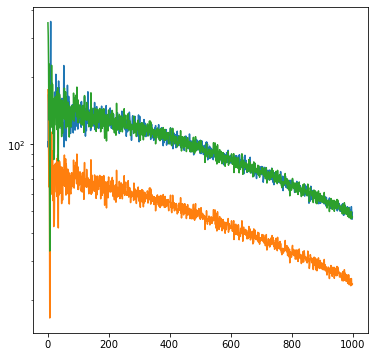

In [8]:
%matplotlib inline
fig,ax = plt.subplots(figsize=(6,6))

ax.plot(cl_SSSS[:1000])
ax.plot(cl_SSpSSp[:1000])
ax.plot(2*cl_SSpSSp[:1000])
ax.set_yscale('log')

In [9]:
fg_alms = hp.fitsfunc.read_alm("/global/cscratch1/sd/maccrann/cmb/ksz/cib_only_fcut7/prep_map/no_cmb/fg_alms_0093.fits")

(1e-06, 0.001)

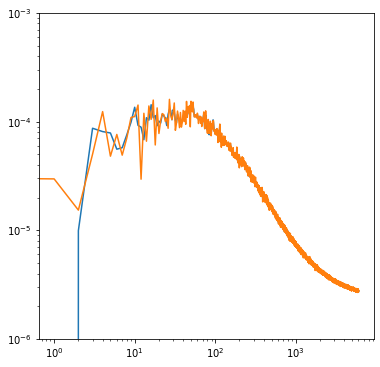

In [10]:
cl_fg_from_alms = curvedsky.alm2cl(fg_alms)
%matplotlib inline
fig,ax = plt.subplots(figsize=(6,6))
ax.plot(cl_fg)
ax.plot(cl_fg_from_alms)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim([1.e-6,1.e-3])

In [11]:
fg_alms_filtered = filter_alms(fg_alms)

In [12]:
K_fg = qfunc(fg_alms_filtered,fg_alms_filtered)

/global/u1/m/maccrann/cmb/lensing/code/falafel/falafel/qe.py:486: RuntimeWarning: divide by zero encountered in true_divide
  salm=cs.almxfl(salm,1./profile)


In [13]:
cl_KK = curvedsky.alm2cl(K_fg)

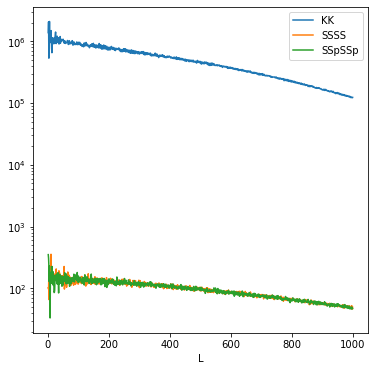

In [14]:
%matplotlib inline
fig,ax = plt.subplots(figsize=(6,6))
ax.plot(cl_KK[:1000], label='KK')
ax.plot(cl_SSSS[:1000], label='SSSS')
ax.plot(2*cl_SSpSSp[:1000], label='SSpSSp')
ax.legend()
ax.set_yscale('log')
ax.set_xlabel("L")
fig.savefig("N0_test_lmin%d_lmax%d.png"%(lmin,lmax))